<a href="https://colab.research.google.com/github/anatasyatata/Portofolio/blob/main/Walmart_Clustering_with_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

no invoice id

We will make a costumer segmentation with RFM segmentation. RFM segmentation is a way to group customers based on recency, frequency, and monetary value of the costumers.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

url = 'https://raw.githubusercontent.com/anatasyatata/Stunting/refs/heads/main/Walmart_customer_purchases.csv'
df = pd.read_csv(url)

In [ ]:
df.head()

,Customer_ID,Age,Gender,City,Category,Product_Name,Purchase_Date,Purchase_Amount,Payment_Method,Discount_Applied,Rating,Repeat_Customer
0,84607c1f-910c-44d5-b89f-e1ee06dd34c0,49,Female,New Cynthia,Electronics,Smartphone,2024-08-30,253.26,Cash on Delivery,No,1,Yes
1,f2a81712-a73e-4424-8b39-4c615a0bd4ea,36,Other,Cruzport,Clothing,T-Shirt,2024-12-21,73.19,Debit Card,Yes,1,No
2,da9be287-8b0e-4688-bccd-1a2cdd7567c6,52,Male,Jeffreytown,Beauty,Perfume,2024-12-26,125.62,Credit Card,Yes,1,No
3,50ec6932-3ac7-492f-9e55-4b148212f302,47,Female,Jenniferburgh,Electronics,Smartwatch,2024-11-04,450.32,Credit Card,No,2,Yes
4,8fdc3098-fc75-4b0f-983c-d8d8168c6362,43,Other,Kingshire,Electronics,Smartphone,2024-10-07,369.28,Credit Card,Yes,2,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Customer_ID       50000 non-null  object 
 1   Age               50000 non-null  int64  
 2   Gender            50000 non-null  object 
 3   City              50000 non-null  object 
 4   Category          50000 non-null  object 
 5   Product_Name      50000 non-null  object 
 6   Purchase_Date     50000 non-null  object 
 7   Purchase_Amount   50000 non-null  float64
 8   Payment_Method    50000 non-null  object 
 9   Discount_Applied  50000 non-null  object 
 10  Rating            50000 non-null  int64  
 11  Repeat_Customer   50000 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 4.6+ MB


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
# Create RFM dataframe
rfm_df = ((((df.groupby('Customer_ID')
             .agg({'Purchase_Date': 'max', 'Product_Name': 'count', 'Purchase_Amount': 'mean'}))
            .reset_index())
           .rename(columns={'Purchase_Date': 'recency', 'Product_Name': 'frequency', 'Purchase_Amount': 'monetary'}))
          .sort_values('frequency', ascending=False))

# Update recency column
# 2018-10-17 17:30:18 Latest timestamp of order_purchase_timestamp
rfm_df["datetime"] = pd.to_datetime(rfm_df["recency"], format="%Y-%m-%d")  # correct data type
rfm_df["recency"] = pd.to_datetime(rfm_df["datetime"].dt.date)  # keep date only
rfm_df["recency"] = (rfm_df["recency"].max() - rfm_df["recency"]).dt.days  # calculate days from last date in dataset

# Add total spend column (monetary * frequency)
rfm_df["monetary_frequency"] = rfm_df["monetary"] * rfm_df["frequency"]

In [ ]:
rfm_df

,Customer_ID,recency,frequency,monetary,datetime,monetary_frequency
49983,ffeb7cc3-cf6f-4ff9-ae94-d17e90ba957e,135,1,470.20,2024-09-27,470.20
49982,ffeb4eb6-63c3-430b-810d-a86cec08ebb7,227,1,271.14,2024-06-27,271.14
49981,ffeacf99-3628-418a-b75c-ce16bc88ce4b,103,1,229.01,2024-10-29,229.01
49980,ffea6c53-8370-4407-95e1-6a508c3d2243,223,1,363.35,2024-07-01,363.35
49979,ffea2a30-4838-4f55-9148-1694d702f703,254,1,378.07,2024-05-31,378.07
...,...,...,...,...,...,...
4,0008c27f-5b3e-452e-8fb3-dd1744592d14,218,1,194.11,2024-07-06,194.11
3,0008375d-c94d-45aa-9ce4-f2e21777cbd5,342,1,233.91,2024-03-04,233.91
2,0003f5b9-0a75-4108-94e2-e960aa99d2a3,349,1,394.37,2024-02-26,394.37
1,00028cdf-0ea6-493f-9f96-df6d50cfa975,63,1,87.38,2024-12-08,87.38


In [ ]:
# Rank the column per customer
rfm_df["recency_ranked"] = 1 - (rfm_df["recency"].rank() / len(rfm_df))
rfm_df["frequency_ranked"] = rfm_df["frequency"].rank() / len(rfm_df)
rfm_df["monetary_ranked"] = rfm_df["monetary"].rank() / len(rfm_df)
rfm_df["monetary_frequency_ranked"] = rfm_df["monetary_frequency"].rank() / len(rfm_df)
rfm_df["total_ranked_score"] = rfm_df["recency_ranked"] + rfm_df["frequency_ranked"] + rfm_df[
    "monetary_ranked"]  # total score

# Score customer from 1 to 5
rfm_df["recency_group"] = pd.cut(rfm_df["recency_ranked"], bins=[-float('inf'), 0.2, 0.4, 0.6, 0.8, float('inf')],
                                 labels=[1, 2, 3, 4, 5], right=False, include_lowest=True)
rfm_df["frequency_group"] = pd.cut(rfm_df["frequency_ranked"], bins=[-float('inf'), 0.2, 0.4, 0.6, 0.8, float('inf')],
                                   labels=[1, 2, 3, 4, 5], right=False, include_lowest=True)
rfm_df["monetary_group"] = pd.cut(rfm_df["monetary_ranked"], bins=[-float('inf'), 0.2, 0.4, 0.6, 0.8, float('inf')],
                                  labels=[1, 2, 3, 4, 5], right=False, include_lowest=True)
rfm_df["monetary_frequency_group"] = pd.cut(rfm_df["monetary_frequency_ranked"],
                                            bins=[-float('inf'), 0.2, 0.4, 0.6, 0.8, float('inf')],
                                            labels=[1, 2, 3, 4, 5], right=False, include_lowest=True)

In [ ]:
rfm_df

,Customer_ID,recency,frequency,monetary,datetime,monetary_frequency,recency_ranked,frequency_ranked,monetary_ranked,monetary_frequency_ranked,total_ranked_score,recency_group,frequency_group,monetary_group,monetary_frequency_group
49983,ffeb7cc3-cf6f-4ff9-ae94-d17e90ba957e,135,1,470.20,2024-09-27,470.20,0.62788,0.50001,0.93858,0.93858,2.06647,4,3,5,5
49982,ffeb4eb6-63c3-430b-810d-a86cec08ebb7,227,1,271.14,2024-06-27,271.14,0.37735,0.50001,0.53380,0.53380,1.41116,2,3,3,3
49981,ffeacf99-3628-418a-b75c-ce16bc88ce4b,103,1,229.01,2024-10-29,229.01,0.71549,0.50001,0.44650,0.44650,1.66200,4,3,3,3
49980,ffea6c53-8370-4407-95e1-6a508c3d2243,223,1,363.35,2024-07-01,363.35,0.38844,0.50001,0.71854,0.71854,1.60699,2,3,4,4
49979,ffea2a30-4838-4f55-9148-1694d702f703,254,1,378.07,2024-05-31,378.07,0.30451,0.50001,0.74860,0.74860,1.55312,2,3,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0008c27f-5b3e-452e-8fb3-dd1744592d14,218,1,194.11,2024-07-06,194.11,0.40109,0.50001,0.37465,0.37465,1.27575,3,3,2,2
3,0008375d-c94d-45aa-9ce4-f2e21777cbd5,342,1,233.91,2024-03-04,233.91,0.06345,0.50001,0.45636,0.45636,1.01982,1,3,3,3
2,0003f5b9-0a75-4108-94e2-e960aa99d2a3,349,1,394.37,2024-02-26,394.37,0.04445,0.50001,0.78321,0.78321,1.32767,1,3,4,4
1,00028cdf-0ea6-493f-9f96-df6d50cfa975,63,1,87.38,2024-12-08,87.38,0.82585,0.50001,0.15639,0.15639,1.48225,5,3,1,1


In [ ]:
# label customers
def apply_condition(recency, monetary_frequency):
    if recency == 5 and monetary_frequency >= 4:
        return "Champions"
    elif recency >= 3 and monetary_frequency >= 4:
        return "Loyal Customers"
    elif recency >= 4 and monetary_frequency >= 2:
        return "Potential Loyalists"
    elif recency == 5 and monetary_frequency == 1:
        return "New Customers"
    elif recency == 4 and monetary_frequency == 1:
        return "Promising"
    elif recency == 3 and monetary_frequency == 3:
        return "About to Sleep"
    elif recency == 3 and monetary_frequency <= 2:
        return "Need Attention"
    elif recency <= 2 and monetary_frequency == 5:
        return "Can't Lose Them"
    elif recency <= 2 and monetary_frequency >= 3:
        return "At Risk"
    elif recency <= 2 and monetary_frequency <= 2:
        return "Hibernating"
    else:
        return "Error"


rfm_df["rfm_segment"] = rfm_df.apply(lambda row: apply_condition(row["recency_group"], row["monetary_frequency_group"]),
                                     axis=1)

In [ ]:
rfm_df.head(5)

,Customer_ID,recency,frequency,monetary,datetime,monetary_frequency,recency_ranked,frequency_ranked,monetary_ranked,monetary_frequency_ranked,total_ranked_score,recency_group,frequency_group,monetary_group,monetary_frequency_group,rfm_segment
49983,ffeb7cc3-cf6f-4ff9-ae94-d17e90ba957e,135,1,470.20,2024-09-27,470.20,0.62788,0.50001,0.93858,0.93858,2.06647,4,3,5,5,Loyal Customers
49982,ffeb4eb6-63c3-430b-810d-a86cec08ebb7,227,1,271.14,2024-06-27,271.14,0.37735,0.50001,0.53380,0.53380,1.41116,2,3,3,3,At Risk
49981,ffeacf99-3628-418a-b75c-ce16bc88ce4b,103,1,229.01,2024-10-29,229.01,0.71549,0.50001,0.44650,0.44650,1.66200,4,3,3,3,Potential Loyalists
49980,ffea6c53-8370-4407-95e1-6a508c3d2243,223,1,363.35,2024-07-01,363.35,0.38844,0.50001,0.71854,0.71854,1.60699,2,3,4,4,At Risk
49979,ffea2a30-4838-4f55-9148-1694d702f703,254,1,378.07,2024-05-31,378.07,0.30451,0.50001,0.74860,0.74860,1.55312,2,3,4,4,At Risk


In [ ]:
out=rfm_df['rfm_segment'].value_counts(normalize=True).mul(100).round(1).astype(str)+'%'
out=pd.concat([rfm_df['rfm_segment'].value_counts(),out],axis=1)
out.columns=['count','percentage']

In [ ]:
out

,count,percentage
rfm_segment,,
Potential Loyalists,8129,16.3%
Loyal Customers,8067,16.1%
At Risk,8001,16.0%
Hibernating,7952,15.9%
Can't Lose Them,4037,8.1%
Need Attention,3963,7.9%
Champions,3891,7.8%
New Customers,2039,4.1%
About to Sleep,1964,3.9%


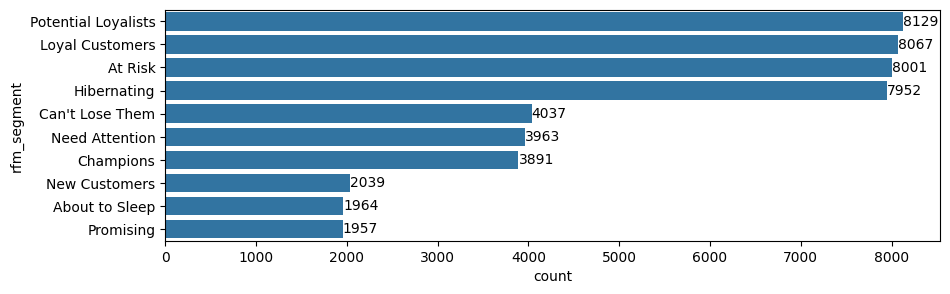

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,3))
ax = sns.barplot(out, x="count", y="rfm_segment",  errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10,);

RFM Customer Segments
1. **Champions** - bought recently, buy often and spend the most
2. **Loyal Customers** - spend good money and often, responsive to promotions
3. **Potential Loyalist** - recent customers, but spent a good amount and bought more than once
4. **New Customers** - bought most recently, but not often
5. **Promising** - recent shoppers, but haven’t spent much
6. **Needing Attention** - above average recency, frequency and monetary values; may not have bought very recently though
7. **About To Sleep** - below average recency, frequency and monetary values; will lose them if not reactivated
8. **At Risk** - spent big money and purchased often but long time ago; need to bring them back
9. **Can't Loose Them** - made biggest purchases, and often but haven’t returned for a long time
10. **Hibernating** - last purchase was long back, low spenders and low number of orders

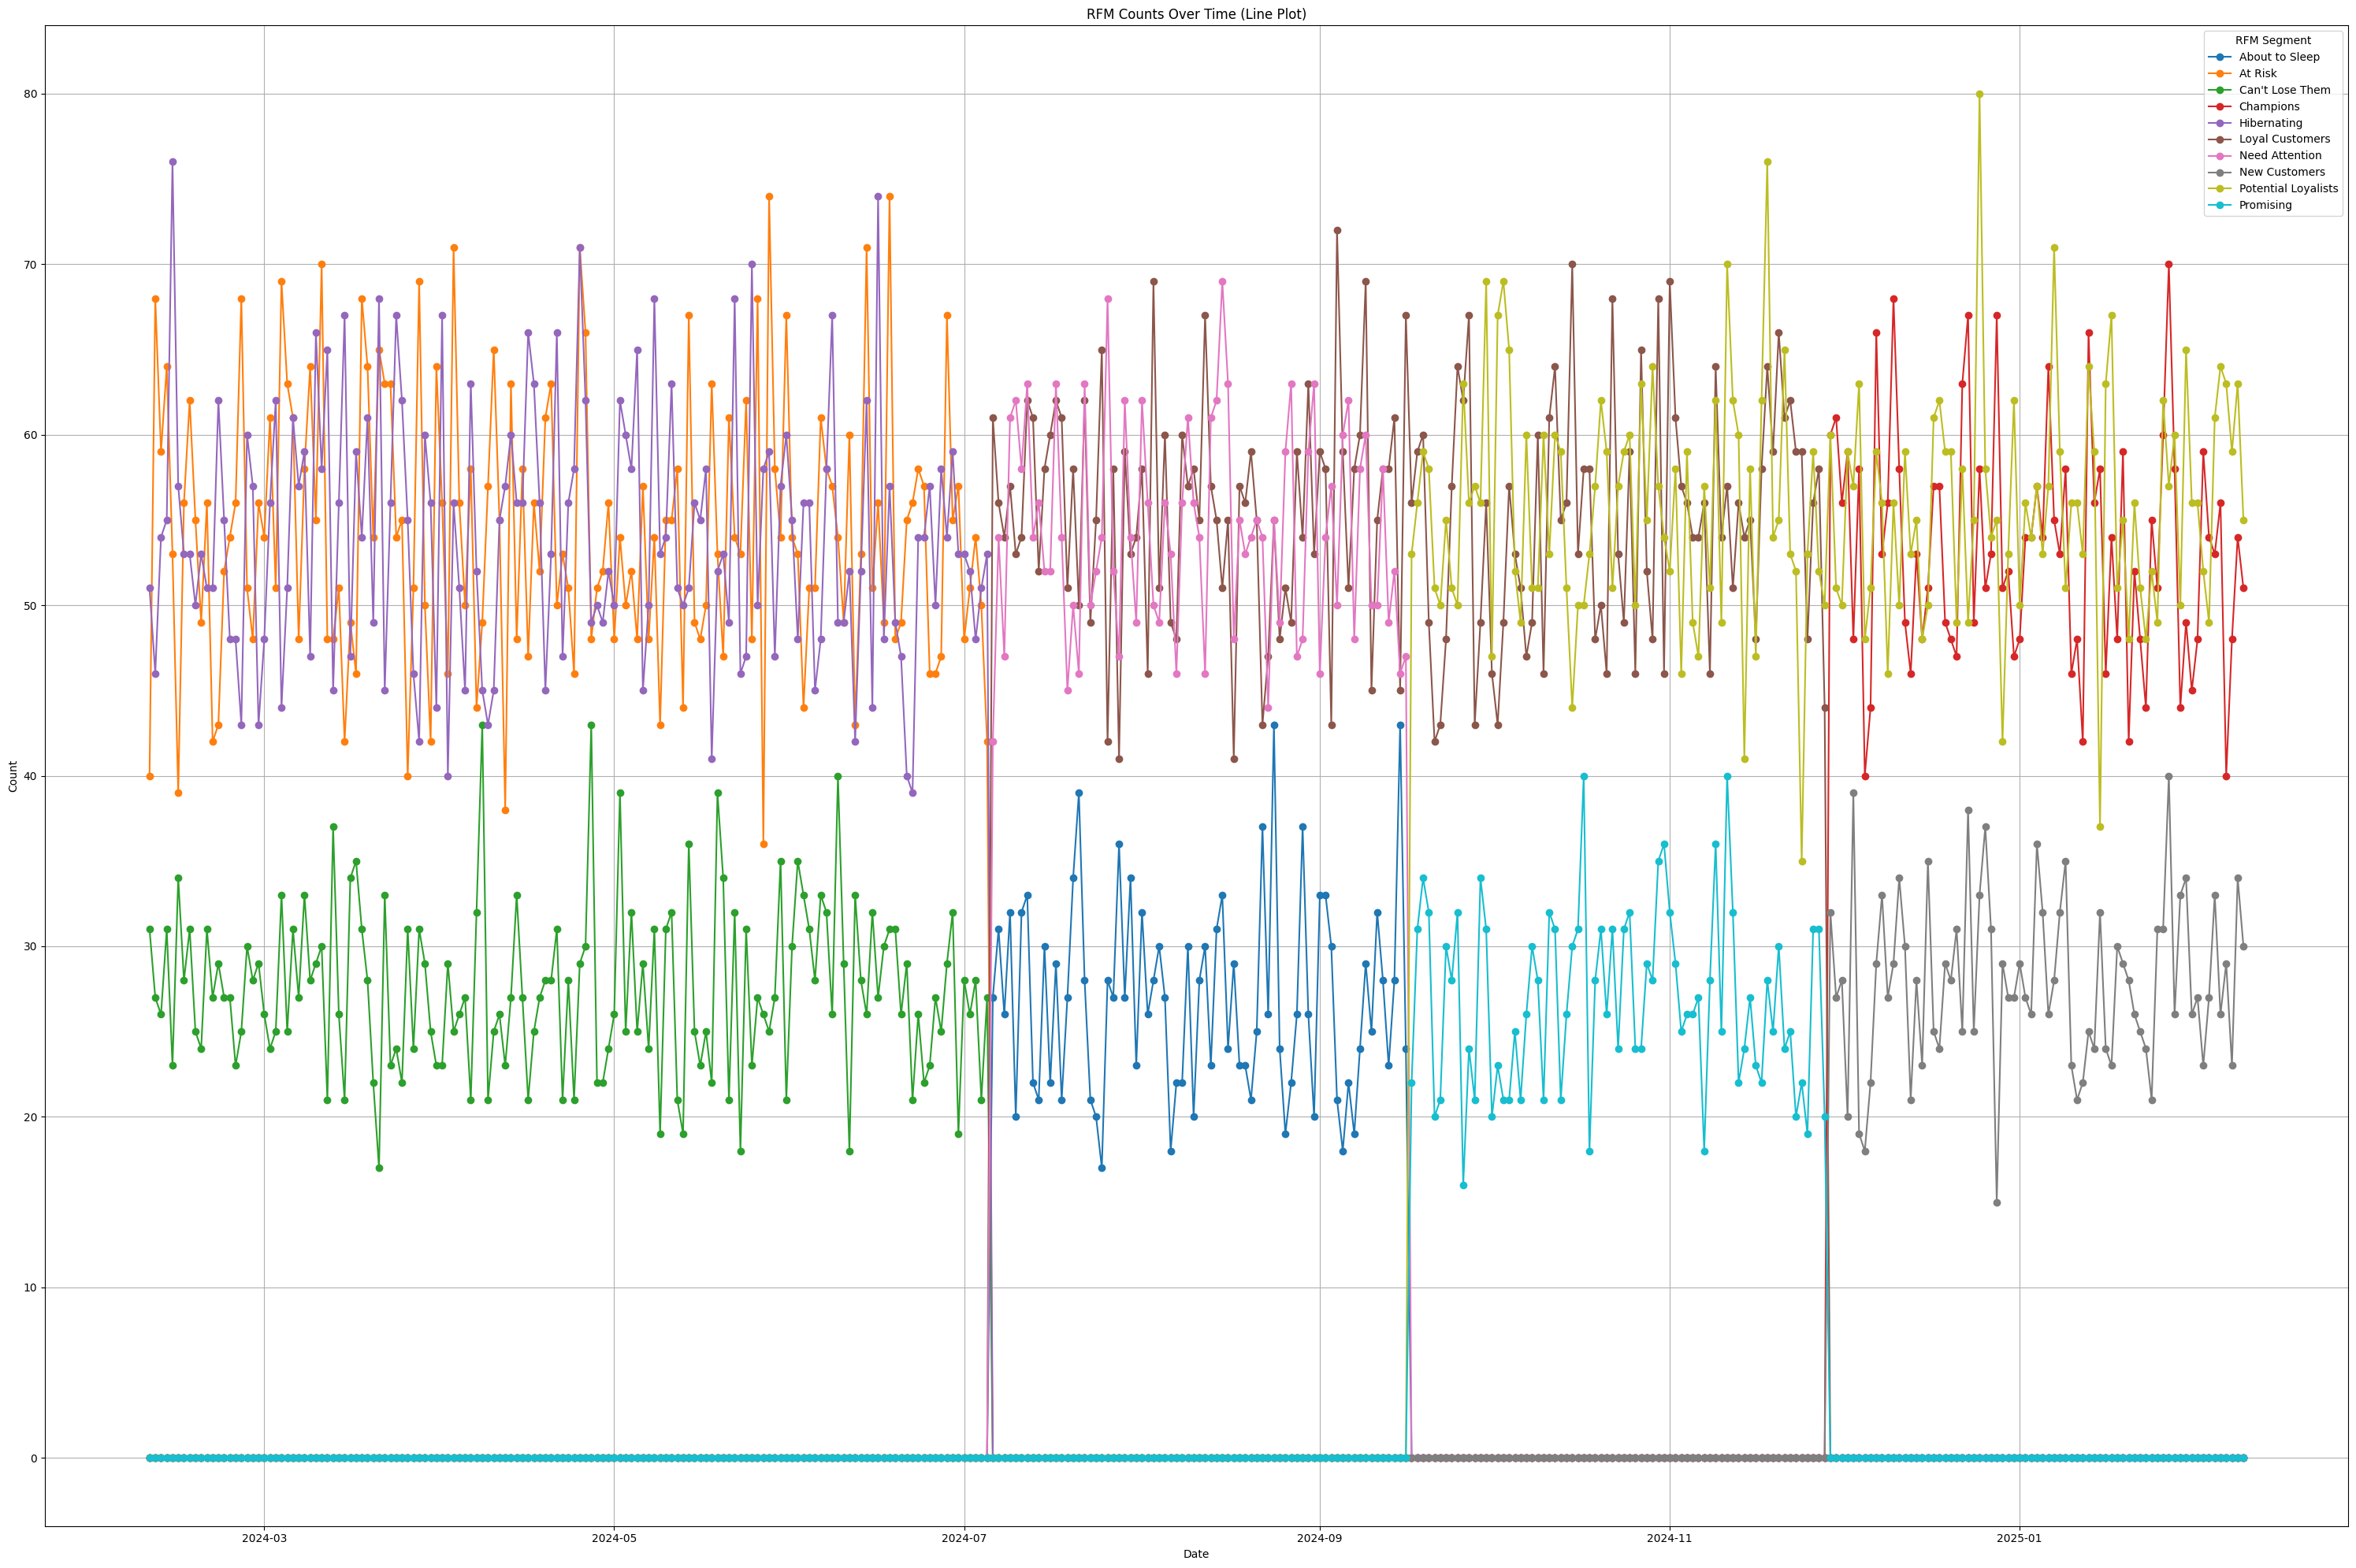

In [ ]:
df1 = pd.DataFrame(rfm_df)
df1['datetime'] = pd.to_datetime(df1['datetime'])

# Step 1: Group by date and category, then count
count_df = df1.groupby(['datetime', 'rfm_segment']).size().unstack(fill_value=0)

# Step 2: Plot
plt.figure(figsize=(30, 20))
for category in count_df.columns:
    plt.plot(count_df.index, count_df[category], marker='o', label=category)

plt.title('RFM Counts Over Time (Line Plot)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='RFM Segment')
plt.grid(True)
plt.tight_layout()
plt.show()